# FP44 Zeeman spectroscopy

Mike Brandt

Juan Provencio

24. April 2023

In [177]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
import numpy as np
from numpy import exp, sqrt, log, pi
from scipy.optimize import curve_fit 
from scipy.stats import chi2
from glob import glob
from astropy.io import fits
from astropy.visualization import simple_norm
import matplotlib.patches as mpatches
import statistics as st
import pandas as pd
from scipy.signal import find_peaks

In [339]:
def fehler(name, G, sig_G, G_lit, sig_G_lit, r = 2, r_lit = 5):
    print(name)
    a = 'Relative error:'
    b = 'Rel. error (comparison): '
    c = 'Absolute error:'
    d = 'Sigma deviation:'
    
    print('Measurements: '.ljust(len(b)), np.round(G, r))
    print('+/-'.rjust(len(b)), np.round(sig_G, r))
    print('Comparison: '.ljust(len(b)), np.round(G_lit, r_lit))
    print('+/-'.rjust(len(b)), np.round(sig_G_lit, r_lit))
    print('\n')
    print(a.ljust(len(b)), sig_G / G * 100)
    print(b.ljust(len(b)), sig_G_lit / G_lit * 100)
    print(c.ljust(len(b)), G - G_lit)
    print(d.ljust(len(b)), np.abs(G - G_lit) / sqrt(sig_G ** 2 
                                                    + sig_G_lit ** 2),'\n')
    
    
def fehler_small(name, G, sig_G):
    print(name)
    print('Relativer Fehler: ', sig_G / G * 100)
    

def result(name, G, sig_G, units, r = 2):

    b = name
    
    print(b + ': ', np.round(G, r))
    print('+/-'.rjust(len(b) + 2), np.round(sig_G, r), units)

'''def result(name, G, sig_G, komma, einheit):
    print(name + ' =', np.round(G, komma), '+/-', np.round(sig_G, komma
                                                          ), einheit)'''
    

def fitparameter(name, G, sig_G, komma, einheit):
    return name + ' =' + str(np.round(G, komma)
                            ) + '$\pm$' + str(np.round(sig_G, komma)
                                             ) + einheit

def chi_sq(test_func, x_val, y_val, sig_y_val, popt, number):
    chi2_ = np.sum((test_func(x_val, *popt) - y_val) ** 2 
                   / sig_y_val ** 2)
    dof = len(y_val) - number
    chi2_red = chi2_ / dof

    print('chi2 =', chi2_)
    print('chi2_red =',chi2_red)

    prob = np.round(1 - chi2.cdf(chi2_,dof), 2) * 100 
    print('Probability =', prob, '%\n')

    
# box design
props = dict(boxstyle = 'round', facecolor = 'white', alpha = 0.5)


# make a box with parameters in plot
def textstrer(title, params, err_params, units, labels, a, b, r = 2, 
              fonts = 14):
    textstr = np.array([title + '\n'])
    
    for i in range(len(params)):
        textstr = np.append(textstr, 
                            '${} = {} \pm {}\ {}$' .
                            format(labels[i],
                                   round(params[i], r),
                                   round(err_params[i], r),
                                   units[i]
                                  )) # Create a textstring w/ all parameters
    plt.text(a, b, ''.join(map(lambda x: x[:] + '\n', textstr)),
            verticalalignment = 'top', fontsize = fonts, bbox = props)

In [179]:
# Color palette:
# 'tomato', 'dodgerblue', 'seagreen', 'gold', ''

## Execution Part 1.

### Magnet field and current

In [180]:
# Increasing and decreasing current, error: read error
I_inc = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]) # A
I_dec = np.array([12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1])
err_I = 0.2 # A 

# Magnetic fields with increasing and decreasing current
B_inc = np.array([ [0.037, 0.033, 0.035], [0.084, 0.082, 0.084], 
                  [0.120, 0.121, 0.122], [0.164, 0.163, 0.163], 
                  [0.201, 0.203, 0.204], [0.238, 0.236, 0.239],
                  [0.280, 0.279, 0.278], [0.316, 0.317, 0.318], 
                  [0.357, 0.356, 0.355], [0.391, 0.390, 0.389], 
                  [0.423, 0.420, 0.421], [0.453, 0.452, 0.449],
                  [0.461, 0.462, 0.463]])
B_dec = np.array([[0.434, 0.445, 0.444], [0.420, 0.421, 0.422], 
                  [0.394, 0.393, 0.390], [0.364, 0.363, 0.365], 
                  [0.312, 0.310, 0.312], [0.277, 0.274, 0.275],
                  [0.242, 0.243, 0.240], [0.201, 0.198, 0.200], 
                  [0.165, 0.166, 0.163], [0.123, 0.122, 0.121], 
                  [0.083, 0.082, 0.084], [0.047, 0.046, 0.049]])
#I_fine = np.array([8, 8.5, 9, 9.5, 10, 10.5, 11, 12, 12.5, 13])
#B_fine = np.array([ [0.308, 0.305, 0.304], [0.328, 0.329, 0.327], [0.354, 0.355, 0.355],
 #                 [0.367, 0.368, 0.365], [0.384, 0.386, 0.385], [0.385, 0.385], 
  #                 [0.409, 0.409], [0.417, 0.417], [0.430, 0.430], [0.450, 0.450] ], dtype = 'object')

Relevant magnetic fields:  [0.311 0.348 0.422 0.459]
                       +/- [0.003 0.004 0.006 0.007] mu T


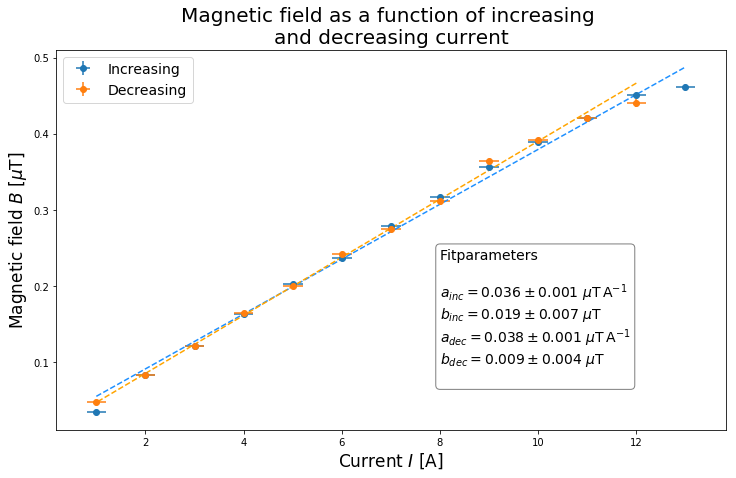

In [365]:
# Get the mean from every 3-point measurement
def meaner(B):
    B_mean = np.array([])
    B_std = np.array([])

    for array in B:
        mean = np.mean(array)
        std = np.std(array)
        B_mean = np.append(B_mean, mean)
        B_std = np.append(B_std, std)
        
    return B_mean, B_std
    
B_mean_inc, B_std_inc = meaner(B_inc)
B_mean_dec, B_std_dec = meaner(B_dec)


# Fit a line
def line(x, a, b):
    return a * x + b


x_inc = np.linspace(I_inc[0], I_inc[-1], 200)
x_dec = np.linspace(I_dec[0], I_dec[-1], 200)
popt_inc, pcov_inc = curve_fit(line, I_inc, B_mean_inc, sigma = B_std_inc)
popt_dec, pcov_dec = curve_fit(line, I_dec, B_mean_dec, sigma = B_std_dec)

params_inc, err_params_inc = popt_inc, sqrt(np.diag(pcov_inc))
params_dec, err_params_dec = popt_dec, sqrt(np.diag(pcov_dec))

params = np.append(params_inc, params_dec)
err_params = np.append(err_params_inc, err_params_dec)

# Plot
plt.figure(figsize = (12, 7))
plt.title('Magnetic field as a function of increasing \nand decreasing current',
          size = 20)
plt.errorbar(I_inc, B_mean_inc, xerr = err_I, yerr = B_std_inc, 
             fmt = 'o', label = 'Increasing')
plt.errorbar(I_dec, B_mean_dec, xerr = err_I, yerr = B_std_dec, 
             fmt = 'o', label = 'Decreasing')

plt.plot(x_inc, line(x_inc, *popt_inc), 
        ls = '--', color = 'dodgerblue')
plt.plot(x_dec, line(x_dec, *popt_dec), 
         ls = '--', color = 'orange')

plt.xlabel('Current $I$ [A]', size = 17)
plt.ylabel('Magnetic field $B$ [$\\mu$T]', size = 17)

plt.legend(loc = 'best', fontsize = 14)


labels = ['a_{inc}', 'b_{inc}', 'a_{dec}', 'b_{dec}']
units = ['\\mu \mathrm{T} \, \mathrm{A}^{-1}', 
         '\\mu \mathrm{T} ', '\\mu \mathrm{T}\, \mathrm{A}^{-1}', 
         '\\mu \mathrm{T} ']
textstrer('Fitparameters', params, err_params, units, labels, 8, 0.25, 3)

plt.savefig('diagrams/B_I_inc_dec.png')

I_891112 = np.array([8, 9, 11, 12])
B_891112 = np.array([])
err_B_891112 = np.array([])

for i in I_891112:
    B_i_inc = line(i, *popt_inc)
    B_i_dec = line(i, *popt_dec)
    B_i, err_B_i = np.mean( (B_i_inc, B_i_dec) ), np.std( (B_i_inc, B_i_dec) )
    
    B_891112, err_B_891112 = (np.append(B_891112, B_i), 
                              np.append(err_B_891112, err_B_i))
    
result('Relevant magnetic fields', B_891112, err_B_891112, 'mu T', 3)

### Observations of Transverse and longitudinal effect

1. The lamp is very pretty, a cool turqouise color
2. Through the LG Plate we can see red light, slightly split in lines
3. After inserting the lambda/4 plate, the lines move in upward and downward direction while turning it
4. After using the polarisation filter and the lambda/4 plate the lines are much clearer and wider apart, the (s/p)-polarized ones have been filtered out.

In the transverse direction: 
we can see all of the 3 lines. After inserting the polarisation filter, the middle line vanishes. The lambda/4 plate then shifts the polarisation of linear to circular and viceversa so we only see the middle line.

In the longitudinal direction: 
We can see the two outermost lines. After inserting the pf, one of the lines vanishes. After the lambda/4 plate, the effect is the opposite and we see the other line.

### Position of lines

In [182]:
''' This tool from 
https://mgarod.medium.com/
dynamically-add-a-method-to-a-class-in-python-c49204b85bd6

helps us to define a class and dynamically add methods to it while we work. 

This is better than redefining every new function once we're done 

I don't know how this works and you don't have to either. 
It's just a nice thing '''
from functools import wraps # This convenience func preserves name and docstring

class OmniTool:
    pass

def add_method(cls):
    def decorator(func):
        @wraps(func) 
        def wrapper(self, *args, **kwargs): 
            return func(*args, **kwargs)
        
        setattr(cls, func.__name__, wrapper)
        # Note we are not binding func, but wrapper which accepts self but does exactly the same as func
        return func # returning func means func can still be used normally
    return decorator

In [183]:
''' Some gauss functions for later '''
def gaussian(x, a, b, c, d):
    return a * exp(- (x - b) ** 2 / (2 * c ** 2)) + d


def double_gaussian(x, a1, b1, c1, a2, b2, c2, d):
    return (gaussian(x, a1, b1, c1, d = 0) +
            gaussian(x, a2, b2, c2, d))


def triple_gaussian(x, a1, a2, a3, b1, b2, b3, c1, c2, c3, d):
    return (gaussian(x, a1, b1, c1, d = 0) 
            + gaussian(x, a2, b2, c2, d = 0) 
            + gaussian(x, a3, b3, c3, d))

In [349]:
''' We create our class, our toolkit into which we will
append all the useful tools we create during this evaluation '''

class OmniTool:
    pass

# We add the method tolino to read the data from the csv
@add_method(OmniTool)
def tolino(file):
    data_i = pd.read_csv(file)
    pos_i = data_i['x'].values
    int_i = data_i['intensity'].values
    int_i = (int_i - min(int_i)) * 1e-7
    
    return pos_i[:-1], int_i[:-1]


file_12 = 'data/Teil 1/12.csv'
data_12 = OmniTool().tolino(file_12)  

# Need the () after OmniTool to initialize the class itself or sth

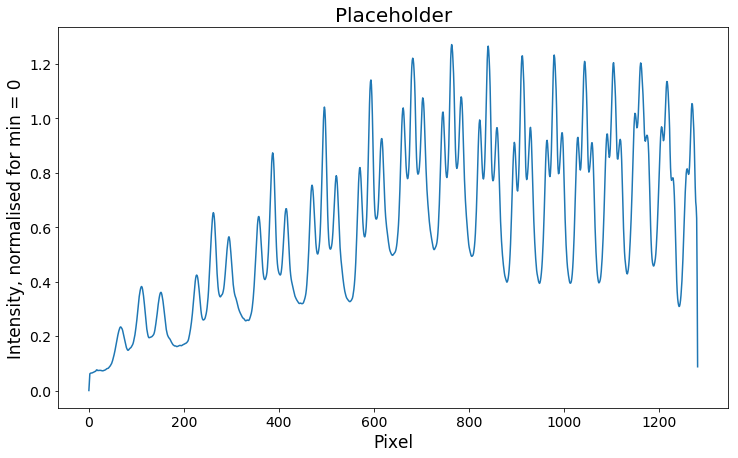

In [351]:
''' First we visualize our data by definining a method
to automatically plot the position and the intensity '''

@add_method(OmniTool)
def plotter(file):
    data = OmniTool().tolino(file)
        
    x = np.linspace(data[0][0], data[0][-1], 2000)

    fig = plt.figure(figsize = (12, 7))
    plt.plot(data[0], data[1], label = 'Measurements')
    plt.title('Title', size = 20)
    plt.xlabel('Pixel', size = 17)
    plt.xticks(size = 14)
    plt.ylabel('Intensity, normalised for min = 0', size = 17)
    plt.yticks(size = 14)
    
    return fig


fig = OmniTool().plotter(file_12)
# We can still manually alter this graph if we want to deviate from
# the standard parameters:
plt.title('Placeholder', size = 20)
plt.show()

In [352]:
''' Next we find the position (and intensity) of every clearly 
discernible peak. We use the find_peaks algorithm and adjust the 
relevant parameters to discriminate between the peaks we want and 
the ones we don't want'''

@add_method(OmniTool)
def peaker(file, ds = 8, prom = 0.008, ht = 0, 
           dis_b = None, dis_a = None):
    data = OmniTool().tolino(file)

    peaks, _ = find_peaks(data[1], distance = ds, 
                          prominence = prom, height = ht)
    peaks = peaks[dis_a:dis_b] # Cut the last one out, only two peaks visible
    heights = data[1][peaks]

    return peaks, heights

peaks, heights = OmniTool().peaker(file_12, dis_b = -2)

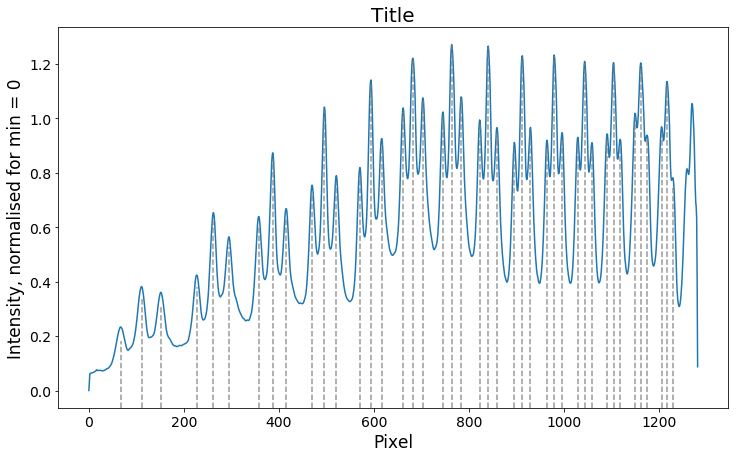

In [353]:
''' Next we take a look at the peaks we've found and manually adjust
the arguments to prune the peaks we're not interested in.

For that we define a method to show us the peaks we've found '''

@add_method(OmniTool)
def peak_marker(peaks, heights, col = 'gray', lab = None, alph = 0.8):
    for i in range(len(peaks)):
        if i == 0:
            _, _, _, ymax = plt.axis() # This we want so that we can
            # automatically rescale the vertical lines and make
            # our plot less cluttered
            plt.axvline(peaks[i], ls = '--', alpha = alph, 
                        color = col, label = lab, 
                        ymax = heights[i] / ymax)
        else:
            plt.axvline(peaks[i], ls = '--', alpha = alph,
                       color = col, ymax = heights[i] / ymax)


fig = OmniTool().plotter(file_12)
OmniTool().peak_marker(peaks, heights) # In the original peaks, there are
# 2 peaks in need of a third one to complete the triplet. We remove these
# manually upstairs ^ with dis_b = - 2, to cut the last two peaks from the
# list

In [355]:
''' For the fits we want to group every peak to its corresponding
triplet '''

@add_method(OmniTool)
def grouper(file, peaks, heights):
    data = OmniTool().tolino(file)
#    peaks, heights = OmniTool().peaker(file)

    a = int(len(peaks) / 3)
    ps = np.array([[0, 0, 0]]) # need this to append to the right dimension
    maxs = np.array([[0, 0, 0]])

    for i in range(a): # Find the position and the height of the peak
        pl_i, maxl_i = peaks[0::3][i], data[1][peaks[0::3][i]]
        pc_i, maxc_i = peaks[1::3][i], data[1][peaks[1::3][i]]
        pr_i, maxr_i = peaks[2::3][i], data[1][peaks[2::3][i]]

        p_i, max_i = [pl_i, pc_i, pr_i], [maxl_i, maxc_i, maxr_i]
        ps, maxs = (np.append(ps, [p_i], axis = 0), 
                    np.append(maxs, [max_i], axis = 0))


    ps = ps[1:]
    maxs = maxs[1:]

    return ps, maxs
    
groups = OmniTool().grouper(file_12, peaks, heights)

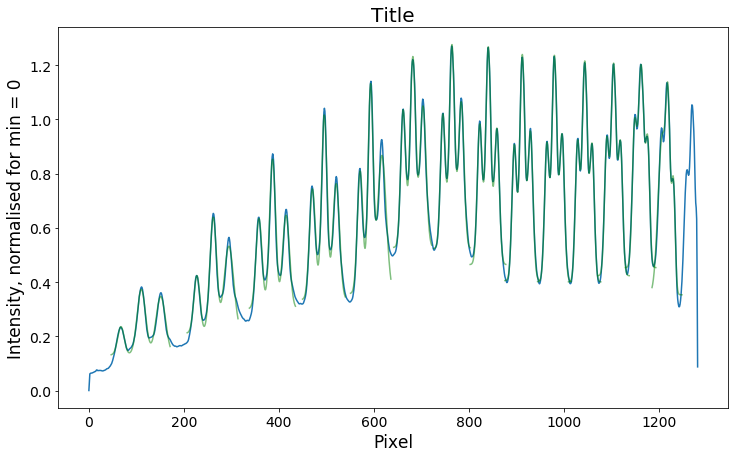

In [356]:
''' Once we have initial guesses for each of our peaks in a triplet
we can use them to make an initial parameter guess for a triple 
gaussian '''

@add_method(OmniTool)
def gausser(file, group, 
            col = 'green', 
            alph = 0.5, 
            dim = 10, 
            symcut = 50): 
    # col, alph parameters for the plot
    # dim = num of parameters of triple gaussian (10)
    # symcut for plotting interval for every order
    data = OmniTool().tolino(file)

    c = [1, 4, 1] # guessed parameters for width
    d = 0 # and offset

    # need for right dimensions when appending
    popts = np.empty([1, dim])
    pcovs = np.empty([1, dim])

    for i in range(len(group[0])):
        b = group[0][i] # groups outputs positions, intensities
        a = group[1][i]

        # closeup on one order
        data_ab = (data[0][int(b[0]) - symcut:int(b[2]) + symcut], 
                   data[1][int(b[0]) - symcut:int(b[2]) + symcut])

        # estimated parameters based on peak finding algorithm
        p0_i = np.append(a, (b, c))
        p0_i = np.append(p0_i, d)

        try: # try in case optimal parameters not found
            popt_i, pcov_i = curve_fit(triple_gaussian, data_ab[0], 
                                       data_ab[1], p0 = p0_i)

            popts = np.append(popts, [popt_i], axis = 0)
            pcovs = np.append(pcovs, [sqrt(np.diag(pcov_i))], axis = 0)

            x_ab = np.linspace(data_ab[0][0], data_ab[0][-1], 200)

            if i == 0:
                plt.plot(x_ab, triple_gaussian(x_ab, *popt_i), 
                         color = col, alpha = alph, label = 'Fits')
            else:
                plt.plot(x_ab, triple_gaussian(x_ab, *popt_i), 
                         color = col, alpha = alph)
        except:
            j = 0 # Empty except block

    popts = popts[1:] # eliminate that empty
    pcovs = pcovs[1:]

    return popts, pcovs

fig = OmniTool().plotter(file_12)
fits = OmniTool().gausser(file_12, groups, symcut = 20)

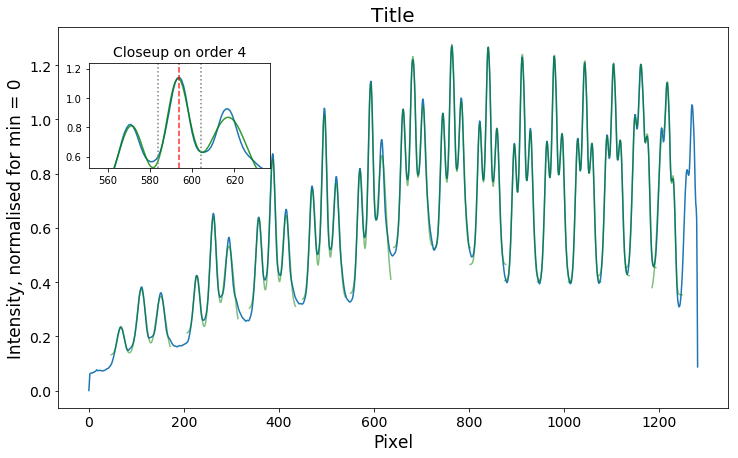

In [357]:
''' For closer manual inspection we can define a magnifying glass 
with a little window that zooms in on a specific order '''
@add_method(OmniTool)
def peeker(file, groups, fits, a,
           pos = [.16, .60, .21, .21], 
           col = 'red', 
           alph = 0.5):
    data = OmniTool().tolino(file)
    
    p0_a = np.append(groups[1][a], groups[0][a],)
    p0_a = np.append(p0_a, [0.9, 10, 1])
    p0_a = np.append(p0_a, 0)

    data_ab_0 = (data[0][int(p0_a[3]) - 50:int(p0_a[5]) + 50], 
                 data[1][int(p0_a[3]) - 50:int(p0_a[5]) + 50])
    x_ab = np.linspace(p0_a[3] - 20, p0_a[5] + 20, 200)

    # Plot for little window
    axes = plt.axes(pos, facecolor = 'white')
    plt.plot(data_ab_0[0], data_ab_0[1])
    plt.plot(x_ab, triple_gaussian(x_ab, *fits[0][a]), 
             color = col, alpha = alph)

    plt.xlim(p0_a[3] - 20, p0_a[5] + 20)
    plt.ylim(p0_a[0] - 0.3, p0_a[1] + 0.1)
    plt.axvline(p0_a[4] - p0_a[7], ls = 'dotted', color = 'gray')
    plt.axvline(p0_a[4] + p0_a[7], ls = 'dotted', color = 'gray')
    plt.axvline(p0_a[4], ls = '--', color = 'red', alpha = 0.8)
    plt.title('Closeup on order ' + str(a), size = 14)

    
fig = OmniTool().plotter(file_12)
fits = OmniTool().gausser(file_12, groups, symcut = 20)
lil_window = OmniTool().peeker(file_12, groups, fits, 4, 
                               col = 'green', alph = 0.8)

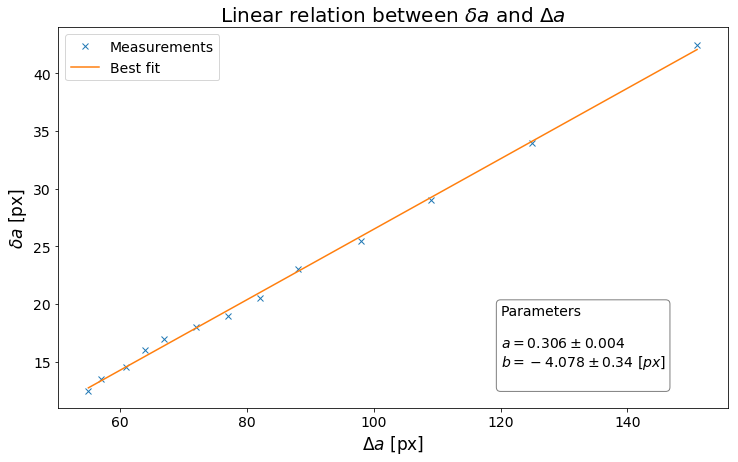

In [191]:
''' We're done with the first part about plotting and fitting every single
order of our Zeeman spectrum. Now we want to identify relevant information,
like the separation Delta a between orders and delta a within an order '''
@add_method(OmniTool)
def delter(peaks):
    Delta_a = np.array([])
    delta_a = np.array([])
    for i in range(int(len(peaks) / 3 - 1)):
        Delta_a_i = np.abs(peaks[1::3][i + 1] - peaks[1::3][i])
        delta_a_i_l = np.abs(peaks[1::3][i] - peaks[0::3][i])
        delta_a_i_r = np.abs(peaks[1::3][i] - peaks[2::3][i])
        
        delta_a_i = np.mean((delta_a_i_l, delta_a_i_r))
        
        Delta_a = np.append(Delta_a, Delta_a_i)
        delta_a = np.append(delta_a, delta_a_i)
        
        
    # Also make a nice little plot
    x_aa = np.linspace(min(Delta_a), max(Delta_a), 200)

    popt_a, pcov_a = curve_fit(line, Delta_a, delta_a)
    params, err_params = popt_a, sqrt(np.diag(pcov_a))

    fig = plt.figure(figsize = (12, 7))
    plt.title('Linear relation between $\\delta a$ and $\\Delta a$', size = 20)
    plt.xlabel('$\Delta a$ [px]', size = 17)
    plt.xticks(size = 14)
    plt.ylabel('$\delta a$ [px]', size = 17)
    plt.yticks(size = 14)
    plt.plot(Delta_a, delta_a, 'x', label = 'Measurements')
    plt.plot(x_aa, line(x_aa, *popt_a), label = 'Best fit')

    units = ['', '[px]']
    labels = ['a', 'b']
    textstrer('Parameters', params, err_params, units, labels, 120, 20, r = 3)

    plt.legend(loc = 'best', fontsize = 14)

    plt.savefig('diagrams/deltaaDeltaa.png')

    return fig, params, err_params
        
del_aDel_a = OmniTool().delter(peaks)

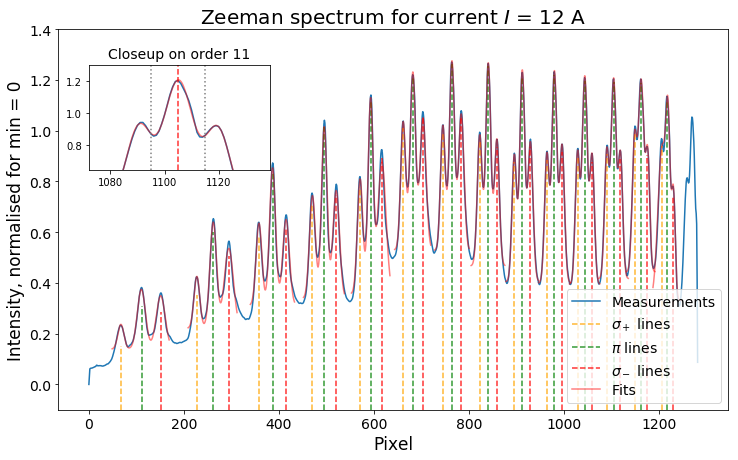

In [358]:
''' --------------------------
Recipe on how to bake our plot 
---------------------------'''

# 1. Plot the data
file = 'data/Teil 1/12.csv'
data = OmniTool().tolino(file)

fig = OmniTool().plotter(file)
plt.title('Zeeman spectrum for current $I$ = 12 A', size = 20)
plt.ylim(-0.1, 1.4)

# 2. Find the peaks
peaks_12, heights = OmniTool().peaker(file, dis_b = -2)

peaks_sig_l, heights_sig_l = peaks_12[0::3], heights[0::3]
peaks_pi, heights_pi = peaks_12[1::3], heights[1::3]
peaks_sig_r, heights_sig_r = peaks_12[2::3], heights[2::3]

OmniTool().peak_marker(peaks_sig_l, heights_sig_l, 
                       col = 'orange', lab = '$\sigma_+$ lines')
OmniTool().peak_marker(peaks_pi, heights_pi, 
                       col = 'green', lab = '$\pi$ lines')
OmniTool().peak_marker(peaks_sig_r, heights_sig_r, 
                       col = 'red', lab = '$\sigma_-$ lines')



# 3. Group triplets
groups = OmniTool().grouper(file, peaks_12, heights)

# 4. Fit a triple Gauss on each triplet
fits_12 = gausser(file, groups, symcut = 18, alph = 0.5, col = 'red')

# 5. Decorate the plot a little more if you like
plt.legend(loc = 'lower right', fontsize = 14)
# Little window
# Fit for order a
# HERE WOULD HAVE BEEN BIN[4]
OmniTool().peeker(file, groups, fits_12, 11)


plt.savefig('diagrams/zeemanspectrum12.png')

HERE WOULD HAVE BEEN BIN[1]

HERE WOULD HAVE BEEN BIN[2]

HERE WOULD HAVE BEEN BIN[3]

In [193]:
@add_method(OmniTool)
def announcer_fits(fits, title = 'Parameters', r = [2, 0], 
                   labels = ['sigma_l', 'pi', 'sigma_r']):
    print(title + '\n')
    
    for i in range(len(fits[0])):
        as_i, err_as_i = fits[0][i][0:3], fits[1][i][0:3]
        bs_i, err_bs_i = fits[0][i][3:6], fits[1][i][3:6]
        cs_i, err_cs_i = fits[0][i][6:9], fits[1][i][6:9]

        print('Order: {}'.format(i))
        print('  {}: a = {} +/- {}   b = {} +/- {} [cov] +/- {} [stat]  [px]'.
              format(labels[0], 
                     round(as_i[0], r[0]), 
                     round(err_as_i[0], r[0]),
                     round(bs_i[0], r[1]), 
                     round(err_bs_i[0], r[1]),
                     round(cs_i[0], r[1]),
                    ))
        print('  {}: a = {} +/- {}   b = {} +/- {} [cov] +/- {} [stat]  [px]'.
              format(labels[1], 
                     round(as_i[1], r[0]), 
                     round(err_as_i[1], r[0]),
                     round(bs_i[1], r[1]), 
                     round(err_bs_i[1], r[1]),
                     round(cs_i[1], r[1]),
                    ))
        print('  {}: a = {} +/- {}   b = {} +/- {} [cov] +/- {} [stat]  [px]'.
              format(labels[2], 
                     round(as_i[2], r[0]), 
                     round(err_as_i[2], r[0]),
                     round(bs_i[2], r[1]), 
                     round(err_bs_i[2], r[1]),
                     round(cs_i[2], r[1]),
                    ))
#        print('Order: {}\n  pi_l:  a = {} +/- {}\n. sigma: a = {} +/- {}'.format(i, round(as_i[0], r), round(err_as_i[0], r)) )
        
        
#announcer_fits(fits)

In [194]:
''' Measurement for I = 8A '''

# 1. Plot the data
file = 'data/Teil 1/8.csv'
data = OmniTool().tolino(file)

fig_8 = OmniTool().plotter(file)
plt.title('Zeeman spectrum for current $I$ = 8 A', size = 20)
plt.ylim(-0.1, 1.2)

# 2. Find the peaks
peaks_8, heights = OmniTool().peaker(file, dis_a = 2, dis_b = -8)

OmniTool().peak_marker(peaks_8, heights, col = 'orange', lab = 'Lines')

# 3. Group triplets
groups = OmniTool().grouper(file, peaks_8, heights)

# 4. Fit a triple Gauss on each triplet
fits_8 = gausser(file, groups, symcut = 18, alph = 0.5, col = 'red')

# 5. Decorate the plot a little more if you like
plt.legend(loc = 'lower right', fontsize = 14)
OmniTool().peeker(file, groups, fits, 0)

plt.savefig('diagrams/zeemanspectrum8.png')
plt.close()

In [195]:
''' Measurement for I = 9A '''

# 1. Plot the data
file = 'data/Teil 1/9.csv'
data = OmniTool().tolino(file)

fig_9 = OmniTool().plotter(file)
plt.title('Zeeman spectrum for current $I$ = 9 A', size = 20)
plt.ylim(-0.1, 1.2)

# 2. Find the peaks
peaks_9, heights = OmniTool().peaker(file, dis_a = 1, dis_b = -4)

OmniTool().peak_marker(peaks_9, heights, col = 'orange', lab = 'Lines')

# 3. Group triplets
groups = OmniTool().grouper(file, peaks_9, heights)

# 4. Fit a triple Gauss on each triplet
fits_9 = gausser(file, groups, symcut = 18, alph = 0.5, col = 'red')

# 5. Decorate the plot a little more if you like
plt.legend(loc = 'lower right', fontsize = 14)
OmniTool().peeker(file, groups, fits_9, 0)

plt.savefig('diagrams/zeemanspectrum9.png')
plt.close()

In [196]:
''' Measurement for I = 11A '''

# 1. Plot the data
file = 'data/Teil 1/11.csv'
data = OmniTool().tolino(file)

fig_11 = OmniTool().plotter(file)
plt.title('Zeeman spectrum for current $I$ = 11 A', size = 20)
plt.ylim(-0.1, 1.2)

# 2. Find the peaks
peaks_11, heights = OmniTool().peaker(file, dis_a = 2)

OmniTool().peak_marker(peaks_11, heights, col = 'orange', lab = 'Lines')

# 3. Group triplets
groups = OmniTool().grouper(file, peaks_11, heights)

# 4. Fit a triple Gauss on each triplet
fits_11 = gausser(file, groups, symcut = 18, alph = 0.5, col = 'red')

# 5. Decorate the plot a little more if you like
plt.legend(loc = 'lower right', fontsize = 14)
OmniTool().peeker(file, groups, fits_11, 0)

plt.savefig('diagrams/zeemanspectrum11.png')
plt.close()

### Orders of interference

In [197]:
# Fit
def polynom(x, a, b, c):
    return a * x ** 2 + b * x + c


# Error for lateral lines
# params: [a, b, c], lines
def error_polynom(params, err_params, lines, err_lines):
    return sqrt( (err_params[0] * lines ** 2) ** 2 
                + (2 * params[0] * err_lines) ** 2 
                + (err_params[1] * lines) ** 2 
                + (params[1] * err_lines) ** 2 
                + (err_params[2]) ** 2)

HERE WOULD HAVE BEEN BIN[5]

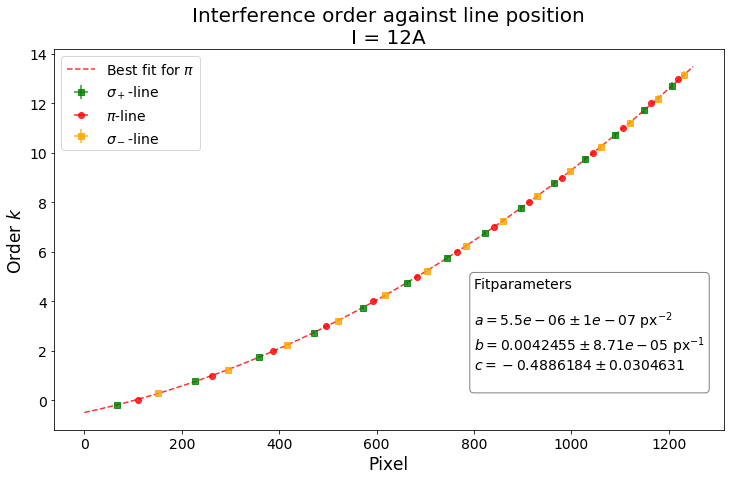

In [198]:
''' We include a method to fit the polynomial to our interference relation
and make a plot, including the orders for the lateral sigma lines. As 
parameters it takes the fitparameters of the triple gaussians and 
parameters to adjust the aesthetic of the diagram. ''' 

@add_method(OmniTool)
def interferer(fits, num, a = 800, b = 5, r = 7):
    # Data points
    
    ks = np.linspace(0, len(fits[0]) - 1, len(fits[0]))

    sigmas_l, err_sigmas_l = fits[0][:, 3], fits[1][:, 6]
    pis, err_pis = fits[0][:, 4], fits[1][:, 7]
    sigmas_r, err_sigmas_r = fits[0][:, 5], fits[1][:, 8]
    
    lines = fits[0][:, 3:6]

    # Fit
    x_pol = np.linspace(0, 1250, 2000)
    popt_pol_p, pcov_pol_p = curve_fit(polynom, pis, ks, sigma = err_pis)

    params = popt_pol_p
    err_params = sqrt(np.diag(pcov_pol_p))
    
    y_err_sigmas_l = error_polynom(params, err_params, sigmas_l, err_sigmas_l)
    y_err_sigmas_r = error_polynom(params, err_params, sigmas_r, err_sigmas_r)

    # Plot
    plt.figure(figsize = (12, 7))
    plt.title('Interference order against line position\nI = ' + num + 'A',
              size = 20)

    plt.errorbar(sigmas_l, polynom(sigmas_l, *popt_pol_p), 
             xerr = err_sigmas_l, yerr = y_err_sigmas_l, fmt = 's', 
             color = 'green', alpha = 0.8, label = '$\sigma_+$-line')
    plt.errorbar(pis, ks, xerr = err_pis, fmt = 'o', 
             color = 'red', alpha = 0.8, label = '$\pi$-line')
    plt.errorbar(sigmas_r, polynom(sigmas_r, *popt_pol_p), 
             xerr = err_sigmas_r, yerr = y_err_sigmas_r, fmt = 's',
             color = 'orange', alpha = 0.8, label = '$\sigma_-$-line')

    plt.plot(x_pol, polynom(x_pol, *popt_pol_p), 
             label = 'Best fit for $\pi$', 
             color = 'red', alpha = 0.8, ls = '--')

    textstrer('Fitparameters', params, err_params, 
              ['$px$^{-2}', '$px$^{-1}', ''],
              ['a', 'b', 'c'], a, b, r)

    plt.xlabel('Pixel', size = 17)
    plt.xticks(size = 14)
    plt.ylabel('Order $k$', size = 17)
    plt.yticks(size = 14)



    plt.legend(loc = 'best', fontsize = 14)

    return params, err_params

inter_12 = OmniTool().interferer(fits_12, '12')

plt.savefig('diagrams/interferenceposition12.png')

In [342]:
# I = 8A
del_aDel_a_8 = OmniTool().delter(peaks_8)
plt.title('Linear relation between $delta a$ and $\Delta a$\nCurrent $I$ = 8 A'
          , size = 20)
plt.close()

result('del_aDel_a [8]', del_aDel_a_8[1][0], del_aDel_a_8[2][0], '', 3)

del_aDel_a [8]:  0.213
             +/- 0.004 


In [343]:
# I = 9A
del_aDel_a_9 = OmniTool().delter(peaks_9)
plt.title('Linear relation between $delta a$ and $\Delta a$\nCurrent $I$ = 9 A'
          , size = 20)
plt.close()

result('del_aDel_a [9]', del_aDel_a_9[1][0], del_aDel_a_9[2][0], '', 3)

del_aDel_a [9]:  0.246
             +/- 0.005 


In [344]:
# I = 11A
del_aDel_a_11 = OmniTool().delter(peaks_11)
plt.title('Linear relation between $delta a$ and $\Delta a$\nCurrent $I$ = 11 A'
          , size = 20)
plt.close()

result('del_aDel_a [11]', del_aDel_a_11[1][0], del_aDel_a_11[2][0], '', 3)

del_aDel_a [11]:  0.291
              +/- 0.004 


In [345]:
# I = 12A
del_aDel_a_12 = OmniTool().delter(peaks_12)
plt.title('Linear relation between $delta a$ and $\Delta a$\nCurrent $I$ = 12 A'
          , size = 20)
plt.close()

result('del_aDel_a [9]', del_aDel_a_12[1][0], del_aDel_a_12[2][0], '', 3)

del_aDel_a [9]:  0.306
             +/- 0.004 


Text(0, 0.5, '$\\dfrac{\\delta a}{\\Delta a}$')

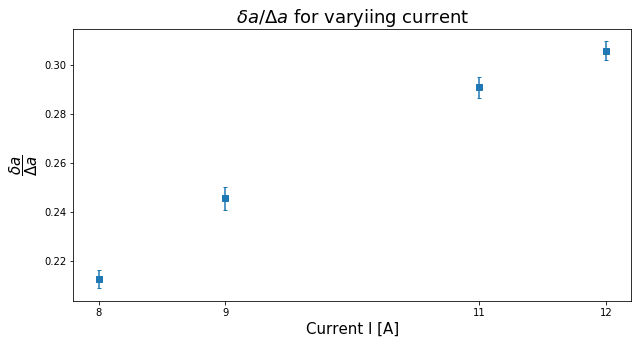

In [324]:
Is = np.array([8, 9, 11, 12])
del_aDel_as = np.array([del_aDel_a_8[1][0], 
                        del_aDel_a_9[1][0], 
                        del_aDel_a_11[1][0], 
                        del_aDel_a_12[1][0]])
err_del_aDel_as = np.array([del_aDel_a_8[2][0], 
                            del_aDel_a_9[2][0], 
                            del_aDel_a_11[2][0], 
                            del_aDel_a_12[2][0]])


plt.figure(figsize = (10, 5))
plt.errorbar(Is, del_aDel_as, yerr = err_del_aDel_as, 
             fmt = 's', capsize = 2)
plt.title('$\delta a / \Delta a$ for varyiing current', size = 18)
plt.xlabel('Current I [A]', size = 15)
plt.xticks([8, 9, 11, 12])
plt.ylabel('$\dfrac{\delta a}{\Delta a}$', size = 15)

Same thing for other currents

In [219]:
# I = 8 A
num = '8'

# 7. Fit interference orders
inter_8 = OmniTool().interferer(fits_8, num)

plt.savefig('diagrams/interferenceposition8.png')
plt.close()

In [220]:
# I = 9 A
num = '9'

# 7. Fit interference orders
inter_9 = OmniTool().interferer(fits_9, num, 750, 5, 8)

plt.savefig('diagrams/interferencepositions9.png')
plt.close()

In [221]:
# I = 11 A
num = '11'

# 7. Fit interference orders
inter_11 = OmniTool().interferer(fits_11, num)

plt.savefig('diagrams/interferencepositions11.png')
plt.close()

HERE WOULD HAVE BEEN BIN[6]

### Determining delta lambda and the Bohr Magneton

In [376]:
# Wavelength of the Cadmium line, from Part 2
lambd, err_lambd = 643.88, 0.23 # nm
d = 4.04 * 1e6 # nm
n = 1.4567
delta_lambda = del_aDel_as * lambd ** 2 / (2 * d * sqrt(n ** 2 - 1))
err_delta_lambda = sqrt( (err_del_aDel_as * lambd ** 2 
                          / (2 * d * sqrt(n ** 2 - 1))) ** 2 
                        + (del_aDel_as * 2 * lambd * err_lambd 
                           / (2 * d * sqrt(n ** 2 - 1))) ** 2 )

result('delta lambda', delta_lambda, err_delta_lambda, 'nm', 5)

delta lambda:  [0.01031 0.01189 0.01408 0.0148 ]
           +/- [0.00019 0.00022 0.0002  0.00018] nm


In [408]:
# Bohr Magneton
h = 6.626 * 1e-34 # J s
c = 3 * 1e8 * 1e9 # nm s^-1
Delta_E = h * c * (1 / lambd - 1 / (lambd + delta_lambda)) * 1e24 # J
err_Delta_E =  h * c * sqrt((err_lambd / (lambd ** 2) )** 2 
                            + (delta_lambda / (lambd + delta_lambda) ** 2)**2)
mu_B = Delta_E / B_891112  # 10^-24 J T^-1
err_mu_B = sqrt( (err_Delta_E / Delta_E) ** 2 
                + (err_B_891112 / B_891112) ** 2) * mu_B


result('Bohr magneton mu_B', mu_B, err_mu_B, 'J T^-1', 2)

Bohr magneton mu_B:  [15.89 16.38 15.99 15.45]
                 +/- [0.17 0.2  0.24 0.25] J T^-1


## Execution Part 2.


#### Calibration with neon lines

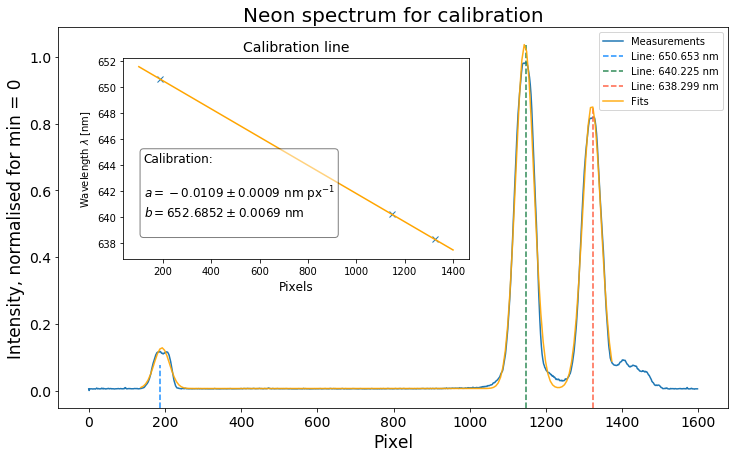

In [286]:
file_neon = 'data/Teil 2/Ne (621-632).csv'
data_neon = OmniTool().tolino(file_neon)
# Plot
OmniTool().plotter(file_neon)
plt.title('Neon spectrum for calibration', size = 20)
# Peaks
# 2. Find peaks
peaks, heights = OmniTool().peaker(file_neon, ds = 1, prom = 0.1, ht = 0.1)
# 2.5 Plot peaks
wls = [650.653, 640.225, 638.299]
labels_wls = [str(wls[0]) + ' nm', str(wls[1]) + ' nm', str(wls[2]) + ' nm']
cols = ['dodgerblue', 'seagreen', 'tomato']

for i in range(len(peaks)):
    OmniTool().peak_marker([peaks[i]], [heights[i]],
                           col = cols[i], 
                           lab = 'Line: ' + labels_wls[i], 
                           alph = 1)

# 3. Group into triplets
groups = OmniTool().grouper(file_neon, peaks, heights)
# 4. Fit
fit_neon = OmniTool().gausser(file_neon, groups, col = 'orange', alph = 0.9)

plt.legend(loc = 'best')

# 4.5 Linear fit for calibration
popt_lin, pcov_lin = curve_fit(line, peaks, wls)
params = popt_lin
err_parmas = sqrt(np.diag(pcov_lin))
units = ['\mathrm{nm\ px}^{-1}', '\mathrm{nm}']
labels = ['a', 'b']

lines_neon, err_lines_neon = (params[1] + params[0] * fit_neon[0][0][3:6], 
                              -params[0] * fit_neon[0][0][6:9])

# Little box
axes = plt.axes([.2, .42, .4, .4], facecolor = 'white')
plt.plot(peaks, wls, 'x')
plt.title('Calibration line', size = 14)
plt.xlabel('Pixels', size = 12)
plt.ylabel('Wavelength $\lambda$ [nm]')
textstrer('Calibration:', params, err_params, units, 
          labels, 120, 645, r = 4, fonts = 12)

x_lin = np.linspace(100, 1400, 200)
plt.plot(x_lin, line(x_lin, *popt_lin), color = 'orange')

plt.savefig('diagrams/neon_calibration.png')


#### Position of cadmium line

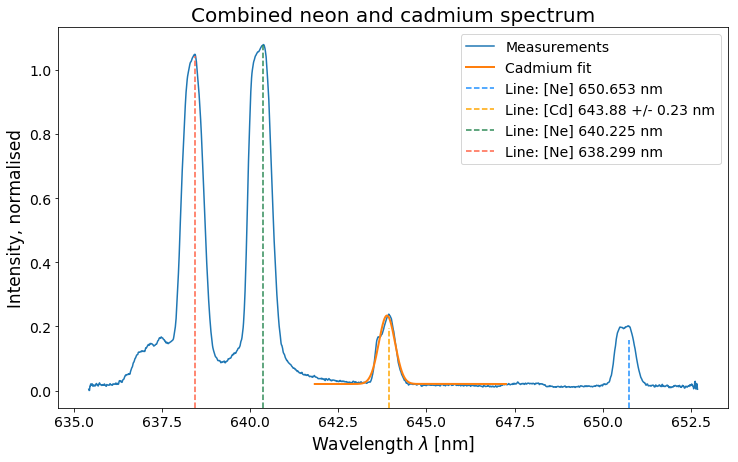

In [319]:
file_cd_ne = 'data/Teil 2/Cd + Ne (621-632).csv'
# Plot
data_cd_ne = OmniTool().tolino(file_cd_ne)
# Adjust the data to give the units in nm
data_cd_ne_wl = params[1] + params[0] * data_cd_ne[0], data_cd_ne[1]

plt.figure(figsize = (12, 7))
plt.plot(data_cd_ne_wl[0], data_cd_ne_wl[1], label = 'Measurements')

plt.title('Combined neon and cadmium spectrum', size = 20)
plt.xlabel('Wavelength $\lambda$ [nm]', size = 17)
plt.xticks(size = 14)
plt.ylabel('Intensity, normalised', size = 17)
plt.yticks(size = 14)

# Find peaks
peaks, heights = OmniTool().peaker(file_cd_ne, prom = 0.1)
peaks = params[1] + params[0] * peaks

# Fit one Gauss
p0_cd = [0.2, 644, 0.01, 0]
x = data_cd_ne_wl[0][500:1000]
y = data_cd_ne_wl[1][500:1000]
popt_cd, pcov_cd = curve_fit(gaussian, x, y, p0 = p0_cd)

line_cd, err_line_cd = np.round(popt_cd[1], 2), np.round(popt_cd[2], 2)

plt.plot(x, gaussian(x, *popt_cd), label = 'Cadmium fit', linewidth = 2)

wls = [650.653, 640.225, 638.299]
labels_wls = ['[Ne] ' + str(wls[0]) + ' nm', 
              '[Cd] ' + str(line_cd) + ' +/- ' + str(err_line_cd) 
              + ' nm', 
              '[Ne] ' + str(wls[1]) + ' nm', 
              '[Ne] ' + str(wls[2]) + ' nm']
cols = ['dodgerblue', 'orange', 'seagreen', 'tomato']

for i in range(len(peaks)):
    OmniTool().peak_marker([peaks[i]], [heights[i]],
                           col = cols[i], 
                           lab = 'Line: ' + labels_wls[i], 
                           alph = 1)
    
    
plt.legend(loc = 'best', fontsize = 14)

plt.savefig('diagrams/neoncadmium.png')

## Discussion

In [409]:
fehler('Linear fits', params_inc, err_params_inc, 
       params_dec, err_params_dec, 3)

params_inc / params_dec

Linear fits
Measurements:             [0.036 0.019]
                      +/- [0.001 0.007]
Comparison:               [0.03815 0.00906]
                      +/- [0.00054 0.00378]


Relative error:           [ 2.5885528  36.14525616]
Rel. error (comparison):  [ 1.42715527 41.71205282]
Absolute error:           [-0.00208838  0.01011089]
Sigma deviation:          [1.93243489 1.2810973 ] 



array([0.94526095, 2.1161185 ])

In [314]:
lines_neon_lit, err_lines_neon_lit = np.array([650.643, 640.225, 638.299]), 0

fehler('Neon lines', lines_neon, err_lines_neon, 
       lines_neon_lit, err_lines_neon_lit, 2)

Neon lines
Measurements:             [650.6  640.26 638.34]
                      +/- [0.22 0.26 0.26]
Comparison:               [650.643 640.225 638.299]
                      +/- 0


Relative error:           [0.0339788  0.04112478 0.04141681]
Rel. error (comparison):  [0. 0. 0.]
Absolute error:           [-0.04063642  0.03089562  0.04587069]
Sigma deviation:          [0.18381958 0.11733829 0.17350153] 



In [316]:
line_cadmium_lit, err_line_cadmium_lit = 643.8470, 0 
# https://physics.nist.gov/PhysRefData/Handbook/Tables/cadmiumtable2_a.htm

fehler('Cadmium line', line_cd, err_line_cd, line_cadmium_lit, err_line_cadmium_lit, 2)

Cadmium line
Measurements:             643.88
                      +/- 0.23
Comparison:               643.847
                      +/- 0


Relative error:           0.03572094179039573
Rel. error (comparison):  0.0
Absolute error:           0.03300000000001546
Sigma deviation:          0.14347826086963245 



In [407]:
# Bohr Magneton
mu_B_lit = 9.27400949 # 10^-24 J T^-1
mu_B_mean, mu_B_std = np.mean(mu_B), np.std(mu_B)

fehler('Bohrs vs Lit', mu_B, err_mu_B, mu_B_lit, 0, 2)
fehler('Bohr vs Lit', mu_B_mean, mu_B_std, mu_B_lit, 0, 2)

Bohrs vs Lit
Measurements:             [15.89 16.38 15.99 15.45]
                      +/- [0.17 0.2  0.24 0.25]
Comparison:               9.27401
                      +/- 0


Relative error:           [1.06056527 1.24748804 1.52278344 1.62707646]
Rel. error (comparison):  0.0
Absolute error:           [6.61547782 7.11049609 6.71206023 6.17631859]
Sigma deviation:          [39.25671275 34.78805694 27.57249065 24.56880432] 

Bohr vs Lit
Measurements:             15.93
                      +/- 0.33
Comparison:               9.27401
                      +/- 0


Relative error:           2.08567652766145
Rel. error (comparison):  0.0
Absolute error:           6.65358818084818
Sigma deviation:          20.02897324852281 



In [406]:
fehler('mu_B [8 vs 9]', mu_B[0], err_mu_B[0], mu_B[1], err_mu_B[1], 2) 
fehler('mu_B [8 vs 11]', mu_B[0], err_mu_B[0], mu_B[2], err_mu_B[2], 2)
fehler('mu_B [8 vs 12]', mu_B[0], err_mu_B[0], mu_B[3], err_mu_B[3], 2)
fehler('mu_B [9 vs 11]', mu_B[1], err_mu_B[1], mu_B[2], err_mu_B[2], 2)
fehler('mu_B [9 vs 12]', mu_B[1], err_mu_B[1], mu_B[3], err_mu_B[3], 2)
fehler('mu_B [11 vs 12]', mu_B[2], err_mu_B[2], mu_B[3], err_mu_B[3], 2)

mu_B [8 vs 9]
Measurements:             15.89
                      +/- 0.17
Comparison:               16.38451
                      +/- 0.20439


Relative error:           1.0605652742328238
Rel. error (comparison):  1.2474880357526343
Absolute error:           -0.49501827303981294
Sigma deviation:          1.868650074045445 

mu_B [8 vs 11]
Measurements:             15.89
                      +/- 0.17
Comparison:               15.98607
                      +/- 0.24343


Relative error:           1.0605652742328238
Rel. error (comparison):  1.5227834357011398
Absolute error:           -0.09658240877014101
Sigma deviation:          0.3262134094650085 

mu_B [8 vs 12]
Measurements:             15.89
                      +/- 0.17
Comparison:               15.45033
                      +/- 0.25139


Relative error:           1.0605652742328238
Rel. error (comparison):  1.627076462120771
Absolute error:           0.43915923368843934
Sigma deviation:          1.4510649307543024 

mu_B 